In [1]:
import glob
import chess_SL_E5_lib as lib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import chess
import numpy as np

In [2]:
lib.fen_str_to_flat_tensor('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

tensor([[-4., -2., -3., -5., -6., -3., -2., -4.],
        [-1., -1., -1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 4.,  2.,  3.,  5.,  6.,  3.,  2.,  4.]])

In [3]:
lib.fen_str_to_3d_tensor('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0., -2.,  0.,  0.,  0.,  0., -2.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.]],

        [[ 0.,  0., -3.,  0.,  0., -3.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0

In [4]:
path = "../Data/DataTrain"

letters_in = 'abcd'
letters_out = 'defg'

# csv_files1 = csv_files2 = glob.glob(f'{path}/Chess_Jan_aa*')

csv_files1 = glob.glob(f'{path}/Chess_Jan_a*') + glob.glob(f'{path}/Chess_Jan_b*') + glob.glob(f'{path}/Chess_Jan_c*') + glob.glob(f'{path}/Chess_Jan_d*')
csv_files2 = glob.glob(f'{path}/Chess_Jan_d*') + glob.glob(f'{path}/Chess_Jan_e*')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Models Trained
- V1 -> Predictor: tensor [64,64]
- V2 -> Predictor: tensor [64,64]
- V3 -> Predictor: tensor [64,64]
- V4 -> Predictor: tensor [64,64]

- E1 -> Epochs: 200, SGD(Learning Rate: 0.030, Momentum = 0.9), Loss: L1Loss, Training: "a*", Validation: "a*" |||| Vars: FEN, white_active, is_check |||| Predictor: CP
- E2 -> Epochs: 200, SGD(Learning Rate: 0.035, Momentum = 0.9), Loss: L1Loss, Training: "a*", Validation: "b*" |||| Vars: FEN, white_active, is_check |||| Predictor: CP
- E3 -> Epochs: 75, Adam(Learning Rate: 0.006, Mometum = 0.9), Loss: L1Loss, Training: "a|b*", Validation: "c|d*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E3.1 -> Epochs: 50, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c*", Validation: "d|e|f*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E3.2 -> Epochs: 40, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e|f|g*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E4.1 -> Epochs: 25, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e|f|g*" |||| Vars: FEN, white_active, is_capture |||| Predictor: CP
- E5.1 -> Epochs: 25, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e*" |||| Vars: FEN |||| Predictor: CP

In [5]:
# Create a dataset
dataset1 = lib.ChessIterableDataset(csv_files1, chunksize = 50000)
dataset2 = lib.ChessIterableDataset(csv_files2, chunksize = 50000)

# Create a data loader
train_data_loader = DataLoader(dataset1, batch_size = 25000)
val_data_loader = DataLoader(dataset2, batch_size = 25000)

# Create a model
model = lib.EvalNet()
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.035, momentum=0.9)

optimizer = optim.Adam(model.parameters(), lr=0.006)

# Train the model
training_loss_history, validation_loss_history = lib.train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs=25)


Begin Training!
Epoch 1/25, Training Loss: 2.28019, Validation Loss: 1.88347
Epoch 2/25, Training Loss: 1.87732, Validation Loss: 1.83374
Epoch 3/25, Training Loss: 1.79568, Validation Loss: 1.76103
Epoch 4/25, Training Loss: 1.76059, Validation Loss: 1.72607
Epoch 5/25, Training Loss: 1.73824, Validation Loss: 1.71121
Epoch 6/25, Training Loss: 1.71814, Validation Loss: 1.70481
Epoch 7/25, Training Loss: 1.70644, Validation Loss: 1.68853
Epoch 8/25, Training Loss: 1.69642, Validation Loss: 1.67803
Epoch 9/25, Training Loss: 1.69289, Validation Loss: 1.67031
Epoch 10/25, Training Loss: 1.67817, Validation Loss: 1.66001
Epoch 11/25, Training Loss: 1.66806, Validation Loss: 1.66060
Epoch 12/25, Training Loss: 1.66060, Validation Loss: 1.64825
Epoch 13/25, Training Loss: 1.65729, Validation Loss: 1.65644
Epoch 14/25, Training Loss: 1.65587, Validation Loss: 1.67370
Epoch 15/25, Training Loss: 1.64552, Validation Loss: 1.64437
Epoch 16/25, Training Loss: 1.63494, Validation Loss: 1.62253
E

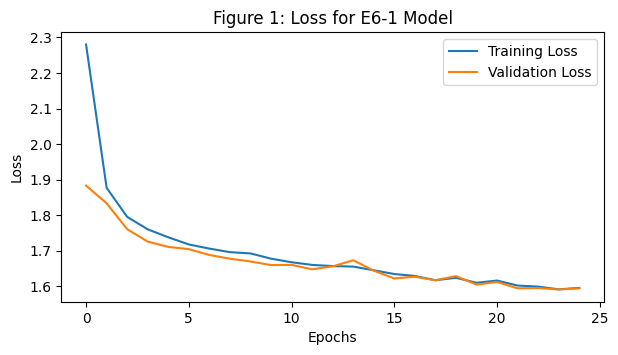

<Figure size 640x480 with 0 Axes>

In [9]:
torch.save(model, 'model_E6.pth')

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3.5))
plt.plot(training_loss_history, label = 'Training Loss')
plt.plot(validation_loss_history, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, None)
plt.title('Figure 1: Loss for E6-1 Model')
plt.legend()
plt.show()
plt.savefig('Loss_E6-1.png')


# NOTE TO SELF - TEST NEW STOCHASTIC PREDICTION FUNCTION

In [7]:
import pickle

pickle.dump(training_loss_history, open('training_loss_history_E5-1.pkl', 'wb'))
pickle.dump(validation_loss_history, open('validation_loss_history_E5-1.pkl', 'wb'))

In [8]:
model_loaded = torch.load('model_E6-1.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'model_E6-1.pth'

In [ ]:
board = chess.Board()

In [ ]:
move = lib.predict(model_loaded, board.fen())
print(move)
board

In [ ]:
board.push_uci(move)
board

In [ ]:
move = lib.predict(model_loaded, board.fen())

In [ ]:
move = 'e4f6'

In [ ]:
# TODO : make prediction function
# TODO : speed up